In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")
from sklearn.decomposition import PCA
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
np.random.seed(42)

/home/inderjeet78/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [2]:
from __future__ import division, print_function, unicode_literals


import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf

tf.reset_default_graph()

np.random.seed(42)
tf.set_random_seed(42)

from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("/tmp/data/")

# Training data prepration

c1_x = mnist.train.images[mnist.train.labels==4]
c1_y = mnist.train.labels[mnist.train.labels==4]
c1_y = c1_y[:,None]
other_x = mnist.train.images[mnist.train.labels!=4]
other_y = mnist.train.labels[mnist.train.labels!=4]
other_y=other_y[:,None]

np.random.seed(42)
c1 = np.concatenate((c1_x,c1_y),axis=1)
others = np.concatenate((other_x,other_y), axis=1)
print(c1.shape)
print(others.shape)
print(others)
np.random.shuffle(others)
others = np.array(others)
print(others.shape)
others321 = others[0:321,:]
print(others321.shape)
train = np.concatenate((c1,others321),axis=0)
np.random.shuffle(train)
X_train = train[:,0:-1]
Y_train = train[:,-1]
Y_train[Y_train==0]=1
Y_train[Y_train==4]=0
Y_train[Y_train!=0]=1

sum(Y_train)

# Validation data prepration

np.random.seed(42)
valX_ones = mnist.validation.images[mnist.validation.labels==4]
valY_ones = mnist.validation.labels[mnist.validation.labels==4]
valX_others = mnist.validation.images[mnist.validation.labels!=4]
valY_others = mnist.validation.labels[mnist.validation.labels!=4]
valY_ones = valY_ones[:,None]
valY_others = valY_others[:,None]
val_ones = np.concatenate((valX_ones,valY_ones),axis=1)
val_others = np.concatenate((valX_others,valY_others),axis=1)
np.random.shuffle(val_others)
val_others137 = val_others[0:137,:]
val = np.concatenate((val_ones,val_others137),axis=0)
np.random.shuffle(val)
valX = val[:,0:-1]
valY = val[:,-1]
valY[valY==0]=1
valY[valY==4]=0
valY[valY!=0]=1

sum(valY)

# Test data prepration

np.random.seed(42)
testX_ones = mnist.test.images[mnist.test.labels==4]
testY_ones = mnist.test.labels[mnist.test.labels==4]
testX_others = mnist.test.images[mnist.test.labels!=4]
testY_others = mnist.test.labels[mnist.test.labels!=4]
testY_ones = testY_ones[:,None]
testY_others = testY_others[:,None]
test_ones = np.concatenate((testX_ones,testY_ones),axis=1)
test_others = np.concatenate((testX_others,testY_others),axis=1)
np.random.shuffle(test_others)
test_others137 = test_others[0:137,:]
test = np.concatenate((test_ones,test_others137),axis=0)
np.random.shuffle(test)
testX = test[:,0:-1]
testY = test[:,-1]
testY[testY==0]=1
testY[testY==4]=0
testY[testY!=0]=1

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
(5307, 785)
(49693, 785)
[[0. 0. 0. ... 0. 0. 7.]
 [0. 0. 0. ... 0. 0. 3.]
 [0. 0. 0. ... 0. 0. 6.]
 ...
 [0. 0. 0. ... 0. 0. 5.]
 [0. 0. 0. ... 0. 0. 6.]
 [0. 0. 0. ... 0. 0. 8.]]
(49693, 785)
(321, 785)


In [3]:
input_dim = X_train.shape[1]

encoding_dim = 700

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(encoding_dim-200, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(encoding_dim-200, activation='tanh')(encoder)
decoder = Dense(encoding_dim, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [4]:
nb_epoch = 10
batch_size = 64
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h4",
                               verbose=0,monitor='val_loss',
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(valX, valX),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 5628 samples, validate on 672 samples
Epoch 1/10
5628/5628 [==============================] - 1s 195us/step - loss: 0.3783 - acc: 0.0112 - val_loss: 0.2608 - val_acc: 0.0030
Epoch 2/10
5628/5628 [==============================] - 1s 173us/step - loss: 0.2074 - acc: 0.0153 - val_loss: 0.1943 - val_acc: 0.0179
Epoch 3/10
5628/5628 [==============================] - 1s 173us/step - loss: 0.1625 - acc: 0.0169 - val_loss: 0.1605 - val_acc: 0.0164
Epoch 4/10
5628/5628 [==============================] - 1s 172us/step - loss: 0.1388 - acc: 0.0163 - val_loss: 0.1422 - val_acc: 0.0060
Epoch 5/10
5628/5628 [==============================] - 1s 175us/step - loss: 0.1206 - acc: 0.0178 - val_loss: 0.1312 - val_acc: 0.0089
Epoch 6/10
5628/5628 [==============================] - 1s 175us/step - loss: 0.1117 - acc: 0.0151 - val_loss: 0.1189 - val_acc: 0.0134
Epoch 7/10
5628/5628 [==============================] - 1s 173us/step - loss: 0.1000 - acc: 0.0130 - val_loss: 0.1066 - val_acc: 0.0119
E

In [5]:
autoencoder = load_model('model.h4')

In [6]:
predictions = autoencoder.predict(testX)
mse = np.mean(np.power(testX - predictions, 2), axis=1)
print(mse.shape)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': testY.reshape(-1)})
error_df.describe()

(1119,)


,reconstruction_error,true_class
count,1119.000000,1119.000000
mean,0.014361,0.122431
std,0.009094,0.327930
min,0.004779,0.000000
25%,0.008656,0.000000
50%,0.011611,0.000000
75%,0.016427,0.000000
max,0.100990,1.000000


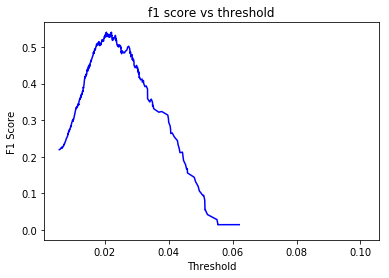

In [7]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(th,(2*recall[1:]*precision[1:])/(precision[1:]+recall[1:]), 'b', label='Precision-Recall curve')
plt.title('f1 score vs threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.show()

In [8]:
index = np.where(2*recall[1:]*precision[1:]==max(2*recall[1:]*precision[1:]))
best_threshold = th[index]
print(best_threshold)

[0.02050309]


# Performance

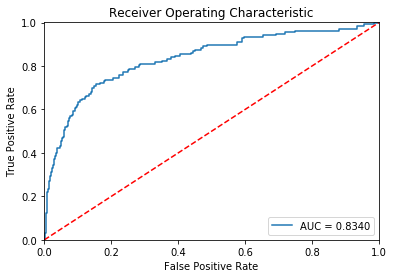

In [9]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

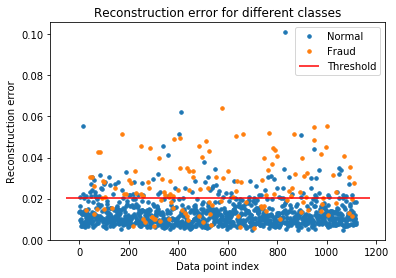

In [10]:
threshold = best_threshold
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

In [11]:
LABELS = ["Normal", "Fraud"]
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
pred = np.array(y_pred)
conf_matrix = confusion_matrix(error_df.true_class, pred)
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score,accuracy_score
print("")
print("Accuracy is : ", accuracy_score(error_df.true_class,pred))
print("")
print("Confusion Matrix is :")
print(conf_matrix)
print("")
print("Classification report is : ")
print("")
print(classification_report(error_df.true_class, pred))


Accuracy is :  0.8677390527256479

Confusion Matrix is :
[[884  98]
 [ 50  87]]

Classification report is : 

             precision    recall  f1-score   support

        0.0       0.95      0.90      0.92       982
        1.0       0.47      0.64      0.54       137

avg / total       0.89      0.87      0.88      1119

